**Shadi Awidat - 322289232**

**Nour Abo El Foul - 206692170**

In [1]:
# @title drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Unzip files
import zipfile
import os

zip_path = 'test_data_images.zip'

extract_dir = 'newtesttemp/'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)

zip_path = 'train_data_images.zip'

extract_dir = 'newtraintemp/'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)


In [3]:
# @title imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torchvision import datasets, transforms
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import cv2
from torchvision.models import resnet18
from torchvision.io import read_image
from torchvision.transforms import ToPILImage, ToTensor

In [ ]:
# @title train form csv
import pandas as pd

train_info = pd.read_csv("/content/drive/MyDrive/Colab/train_validation_data.csv")

artist_image_counts = train_info['artist_name'].value_counts()
artists_with_more_than_2_images = artist_image_counts[artist_image_counts >= 2]
artists_with_less_than_2_images = artist_image_counts[artist_image_counts < 2].index.tolist()

validation_artists_temp = artists_with_more_than_2_images.sample(n=190, random_state=42)
validation_Artists = validation_artists_temp.index.tolist()

unique_artists = artist_image_counts.index.tolist()
print(len(unique_artists))
artist_map = {artist: idx for idx, artist in enumerate(unique_artists)}

train_data = []
validation_data = []

for artist in unique_artists:
    indices = train_info.index[train_info['artist_name'] == artist].tolist()
    k = 10
    if(len(indices) < k and k >= 2):
        k = len(indices)
    train_indices = indices[:k] if ((artist not in validation_Artists) and (artist not in artists_with_less_than_2_images))else []
    validation_indices = indices[:k] if artist in validation_Artists else []
    train_data.extend(train_indices)
    validation_data.extend(validation_indices)

train_set = train_info.iloc[train_data]
train_images = train_set['image_name']

train_labels, unique_artists_train = train_set['artist_name'].factorize()

validation_set = train_info.iloc[validation_data]
validation_images = validation_set['image_name']

validation_labels, unique_artists_validation = validation_set['artist_name'].factorize()
print("number of artists in train: ", len(unique_artists_train))
print("number of artists in validation: ", len(unique_artists_validation))
for i in unique_artists_validation:
  if i in unique_artists_train:
    print("this artist is in both: ", i)

1208
number of artists in train:  772
number of artists in validation:  190


In [ ]:
# @title test from csv
test_info = pd.read_csv("/content/drive/MyDrive/Colab/new_Test.csv")

artist_image_counts = test_info['artist_name'].value_counts()
artists_with_more_than_10_images = artist_image_counts[artist_image_counts >= 2].index.tolist()
unique_artists = artist_image_counts.index.tolist()
artist_map = {artist: idx for idx, artist in enumerate(unique_artists)}
test_data = []
for artist in unique_artists:
    indices = test_info.index[test_info['artist_name'] == artist].tolist()
    k = 10
    if(len(indices) < k and k >= 2):
        k = len(indices)
    test_indices = indices[:k] if artist in artists_with_more_than_10_images else []
    test_data.extend(test_indices)
test_set = test_info.iloc[test_data]

test_images = test_set['image_name']

test_labels, unique_artists = test_set['artist_name'].factorize()
print("number of artists in test: ", len(unique_artists))
for i in unique_artists:
  if i in unique_artists_train:
    print("this artist is in both: ", i)

number of artists in test:  91


In [4]:
# @title network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        resnet = models.resnet18(pretrained=True)

        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])
        self.dropout1 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(25088, 256)
        self.dropout2 = nn.Dropout(0.30)
        self.fc2 = nn.Linear(256, 64)


    def forward_once(self, x):
        x = self.resnet_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def forward(self, input1):
        output1 = self.forward_once(input1)
        return output1

def generate_batches(data, batch_size):
    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batches.append(batch)
    return batches


In [5]:
# @title create triples function and transforms
import random

transform_n = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, scale=(0.8, 1.2), shear=10),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def create_triplets_temp(images, labels, num_pairs,path):
    num_classes = len(np.unique(labels))
    temp = []
    image_dir = path

    for k in range(num_pairs):
        image_label_pairs = list(zip(images, labels))
        label_to_images = {}
        for image, label in image_label_pairs:
            if label not in label_to_images:
                label_to_images[label] = []
            label_to_images[label].append(image)

        anchor_class = k % num_classes
        matching_images = label_to_images[anchor_class]
        img1 , img2 = np.random.choice(matching_images, size=2, replace=False)

        path = image_dir + "/" + img1
        path = image_dir + "/" + img2
        negative_class = np.random.choice(np.unique(labels))

        while negative_class == anchor_class:
            negative_class = np.random.choice(np.unique(labels))
        matching_images = label_to_images[negative_class]

        img3 = np.random.choice(matching_images, size=1, replace=False)[0]

        path = image_dir + "/" + img3

        temp.append([img1,img2, img3])


    return temp

In [6]:
# @title loss
def TripletLoss(anchor ,positive , negative,margin ):
    pos = torch.norm(anchor - positive, p=2, dim=1)
    neg = torch.norm(anchor - negative, p=2, dim=1)
    loss_values = torch.relu(pos - neg + margin)

    return torch.mean(loss_values), pos, neg

In [ ]:
# @title create validation triples and save
# save_path = '/content/drive/MyDrive/Colab/'
# import pickle
# VD = create_triplets_temp(validation_images,validation_labels,6000,"/content/newtraintemp/train_images_11_4")
# with open(save_path + 'triplet_validation_data_final.pkl', 'wb') as f:
#     pickle.dump(VD, f)

In [ ]:
# @title create test triples and save
# import pickle
# TESTD = create_triplets_temp(test_images,test_labels,6000,"/content/newtesttemp/newtest")
# save_path = '/content/drive/MyDrive/Colab/'
# with open(save_path + 'triplet_test_data_final.pkl', 'wb') as f:
#     pickle.dump(TESTD, f)

In [ ]:
# @title loading validation and test triples
# import pickle

# save_path = '/content/drive/MyDrive/Colab/'

# with open(save_path + 'triplet_validation_data_final.pkl', 'rb') as f:
#     VD = pickle.load(f)
# with open(save_path + 'triplet_test_data_final.pkl', 'rb') as f:
#     TESTD = pickle.load(f)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train batch 1 / 150 in epoch 1
Train batch 2 / 150 in epoch 1
Train batch 3 / 150 in epoch 1
Train batch 4 / 150 in epoch 1
Train batch 5 / 150 in epoch 1
Train batch 6 / 150 in epoch 1
Train batch 7 / 150 in epoch 1
Train batch 8 / 150 in epoch 1
Train batch 9 / 150 in epoch 1
Train batch 10 / 150 in epoch 1
Train batch 11 / 150 in epoch 1
Train batch 12 / 150 in epoch 1
Train batch 13 / 150 in epoch 1
Train batch 14 / 150 in epoch 1
Train batch 15 / 150 in epoch 1
Train batch 16 / 150 in epoch 1
Train batch 17 / 150 in epoch 1
Train batch 18 / 150 in epoch 1
Train batch 19 / 150 in epoch 1
Train batch 20 / 150 in epoch 1
Train batch 21 / 150 in epoch 1
Train batch 22 / 150 in epoch 1
Train batch 23 / 150 in epoch 1
Train batch 24 / 150 in epoch 1
Train batch 25 / 150 in epoch 1
Train batch 26 / 150 in epoch 1
Train batch 27 / 150 in epoch 1
Train batch 28 / 150 in epoch 1
Train batch 29 / 150 in epoch 1
Train batch 30 / 150 in epoch 1
Train batch 31 / 150 in epoch 1
Train batch 32 / 

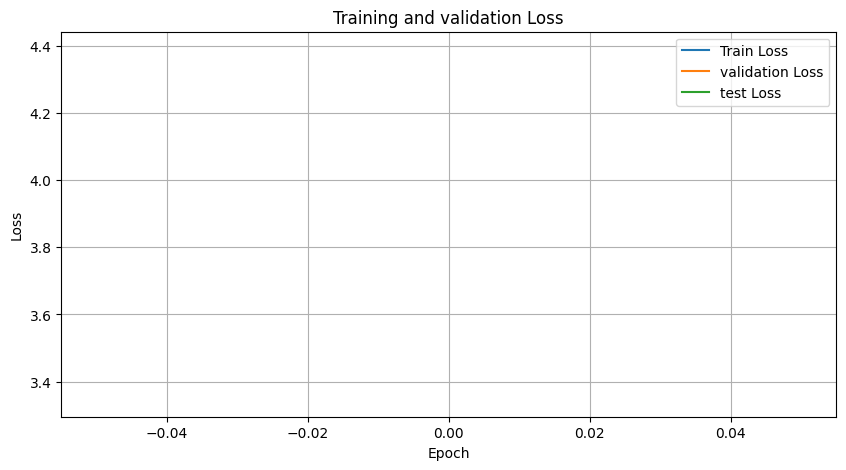

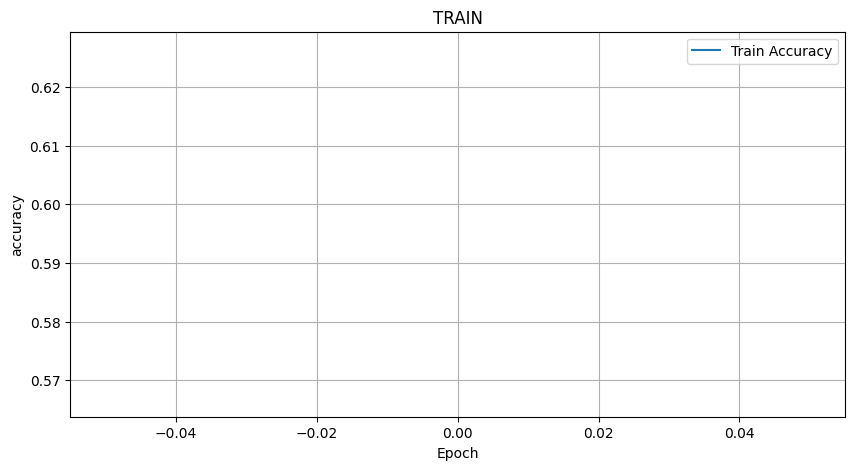

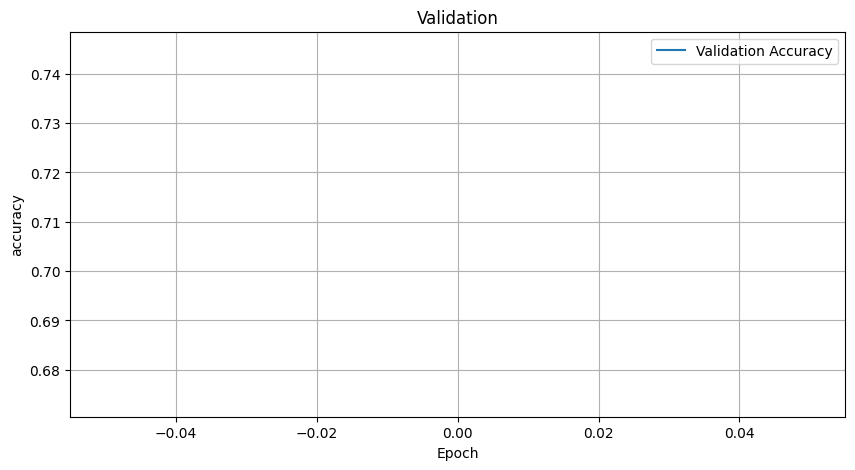

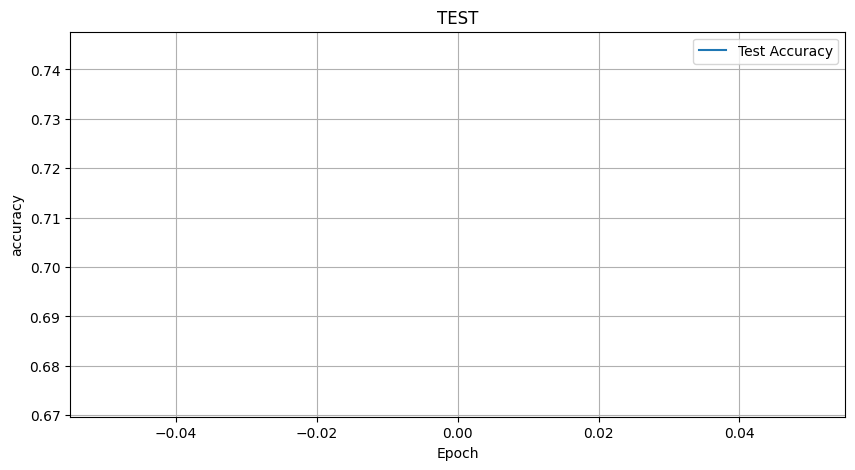

Train batch 1 / 150 in epoch 2
Train batch 2 / 150 in epoch 2
Train batch 3 / 150 in epoch 2
Train batch 4 / 150 in epoch 2
Train batch 5 / 150 in epoch 2
Train batch 6 / 150 in epoch 2
Train batch 7 / 150 in epoch 2
Train batch 8 / 150 in epoch 2
Train batch 9 / 150 in epoch 2
Train batch 10 / 150 in epoch 2
Train batch 11 / 150 in epoch 2
Train batch 12 / 150 in epoch 2
Train batch 13 / 150 in epoch 2
Train batch 14 / 150 in epoch 2
Train batch 15 / 150 in epoch 2
Train batch 16 / 150 in epoch 2
Train batch 17 / 150 in epoch 2
Train batch 18 / 150 in epoch 2
Train batch 19 / 150 in epoch 2
Train batch 20 / 150 in epoch 2
Train batch 21 / 150 in epoch 2
Train batch 22 / 150 in epoch 2
Train batch 23 / 150 in epoch 2
Train batch 24 / 150 in epoch 2
Train batch 25 / 150 in epoch 2
Train batch 26 / 150 in epoch 2
Train batch 27 / 150 in epoch 2
Train batch 28 / 150 in epoch 2
Train batch 29 / 150 in epoch 2
Train batch 30 / 150 in epoch 2
Train batch 31 / 150 in epoch 2
Train batch 32 / 

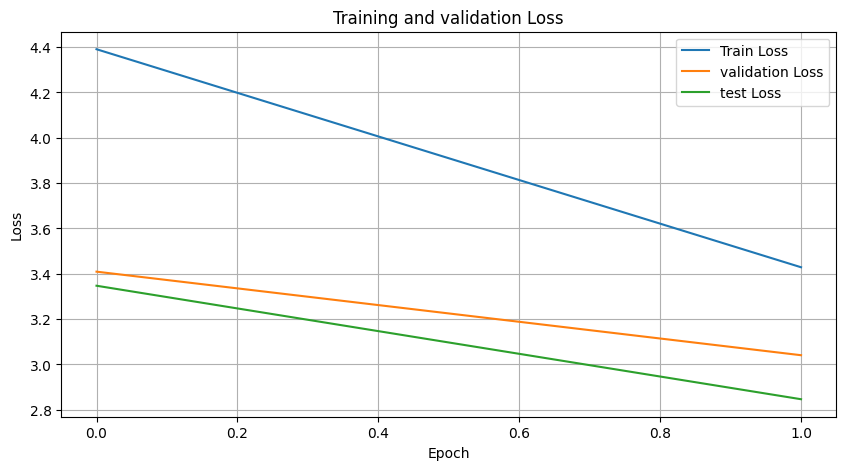

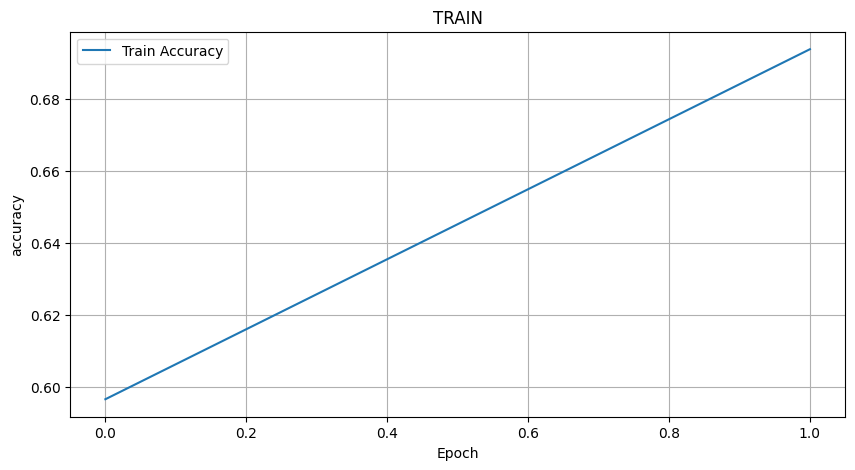

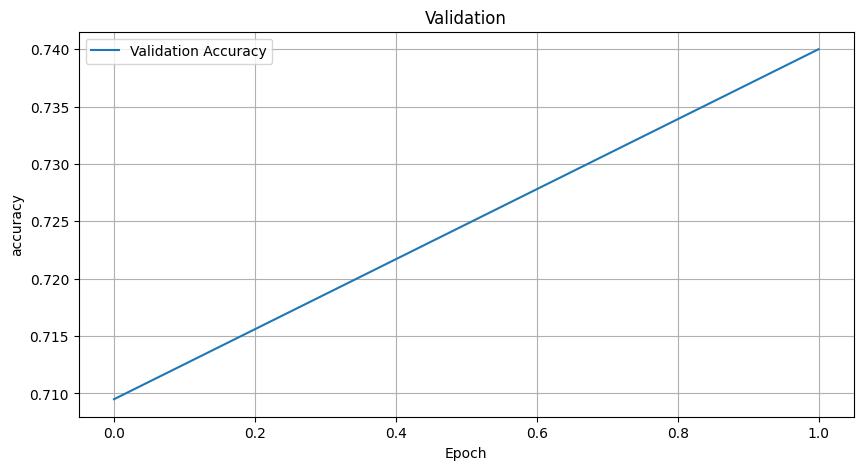

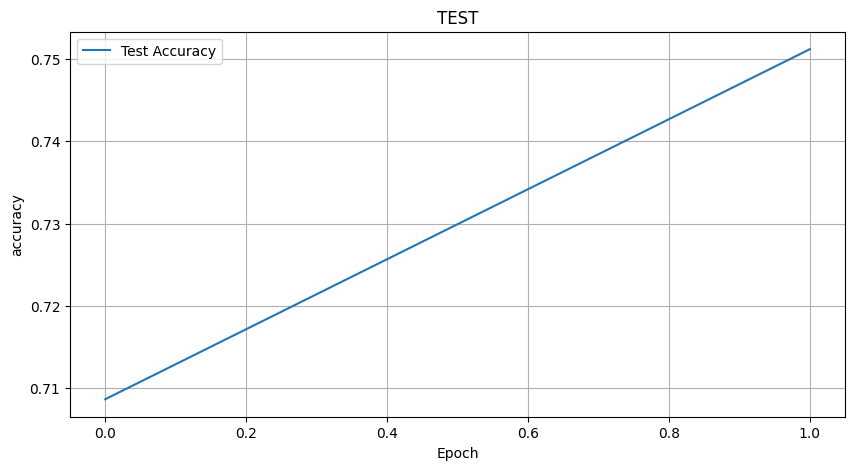

Train batch 1 / 150 in epoch 3
Train batch 2 / 150 in epoch 3
Train batch 3 / 150 in epoch 3
Train batch 4 / 150 in epoch 3
Train batch 5 / 150 in epoch 3
Train batch 6 / 150 in epoch 3
Train batch 7 / 150 in epoch 3
Train batch 8 / 150 in epoch 3
Train batch 9 / 150 in epoch 3
Train batch 10 / 150 in epoch 3
Train batch 11 / 150 in epoch 3
Train batch 12 / 150 in epoch 3
Train batch 13 / 150 in epoch 3
Train batch 14 / 150 in epoch 3
Train batch 15 / 150 in epoch 3
Train batch 17 / 150 in epoch 3
Train batch 18 / 150 in epoch 3
Train batch 19 / 150 in epoch 3
Train batch 20 / 150 in epoch 3
Train batch 21 / 150 in epoch 3
Train batch 22 / 150 in epoch 3
Train batch 23 / 150 in epoch 3
Train batch 24 / 150 in epoch 3
Train batch 25 / 150 in epoch 3
Train batch 26 / 150 in epoch 3
Train batch 27 / 150 in epoch 3
Train batch 28 / 150 in epoch 3
Train batch 29 / 150 in epoch 3
Train batch 30 / 150 in epoch 3
Train batch 31 / 150 in epoch 3
Train batch 32 / 150 in epoch 3
Train batch 33 / 

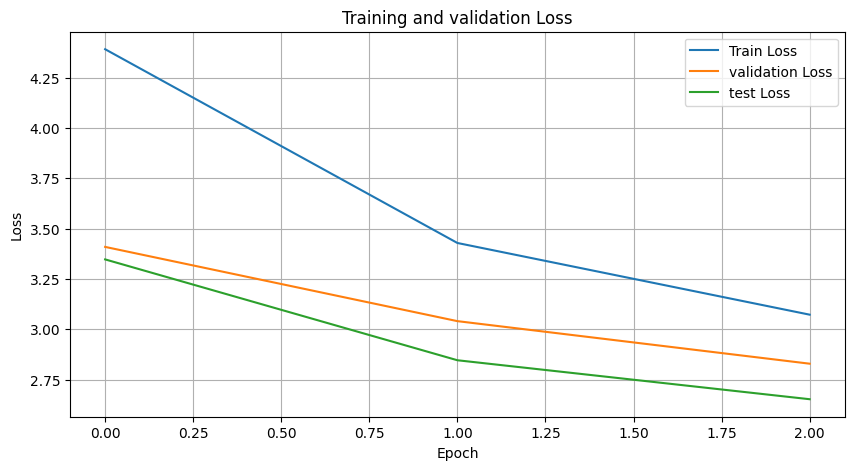

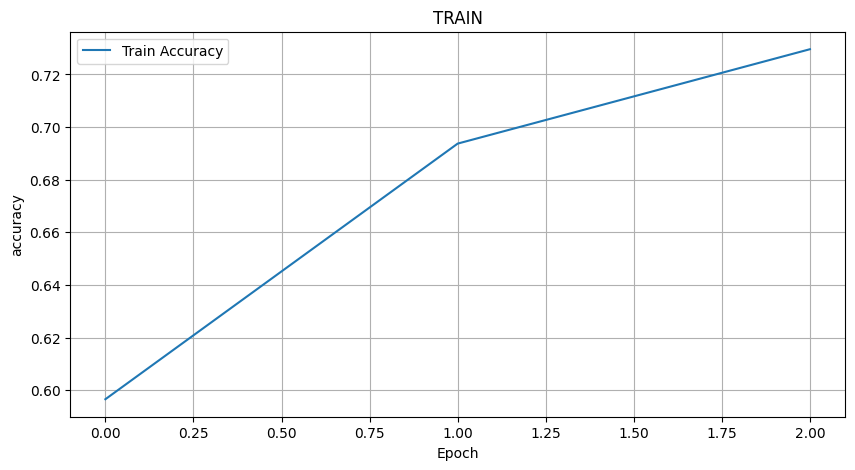

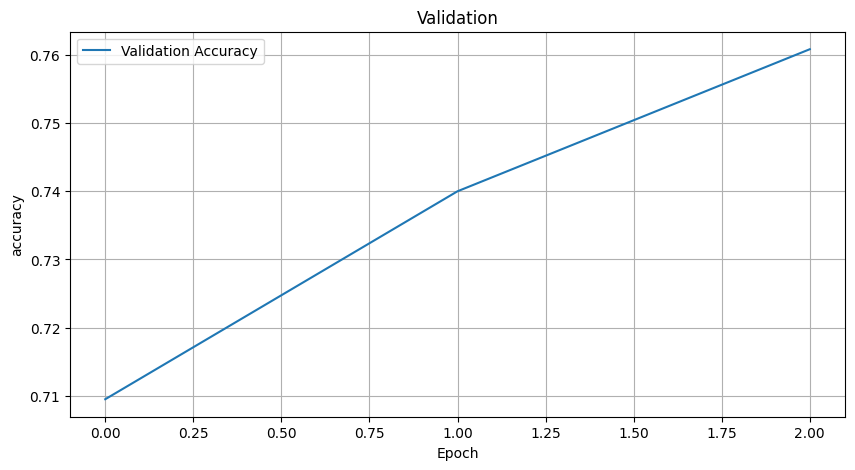

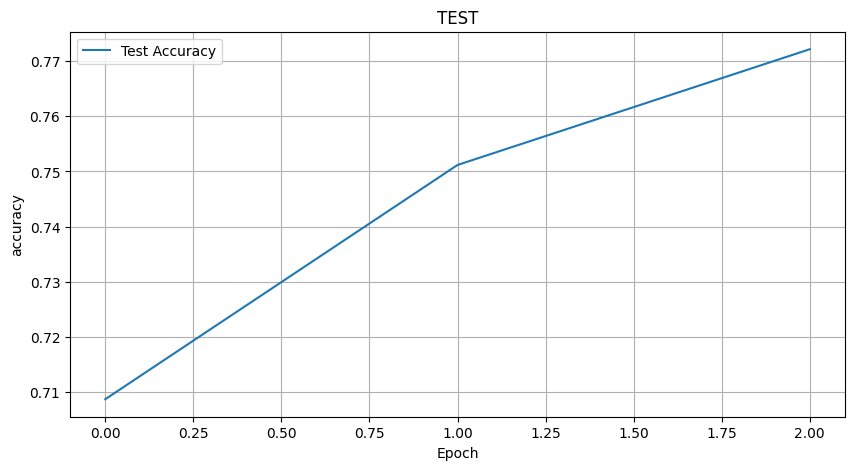

Train batch 1 / 150 in epoch 4
Train batch 2 / 150 in epoch 4
Train batch 3 / 150 in epoch 4
Train batch 4 / 150 in epoch 4
Train batch 5 / 150 in epoch 4
Train batch 6 / 150 in epoch 4
Train batch 7 / 150 in epoch 4
Train batch 8 / 150 in epoch 4
Train batch 9 / 150 in epoch 4
Train batch 10 / 150 in epoch 4
Train batch 11 / 150 in epoch 4
Train batch 12 / 150 in epoch 4
Train batch 13 / 150 in epoch 4
Train batch 14 / 150 in epoch 4
Train batch 15 / 150 in epoch 4
Train batch 16 / 150 in epoch 4
Train batch 17 / 150 in epoch 4
Train batch 18 / 150 in epoch 4
Train batch 19 / 150 in epoch 4
Train batch 20 / 150 in epoch 4
Train batch 21 / 150 in epoch 4
Train batch 22 / 150 in epoch 4
Train batch 23 / 150 in epoch 4
Train batch 24 / 150 in epoch 4
Train batch 25 / 150 in epoch 4
Train batch 26 / 150 in epoch 4
Train batch 27 / 150 in epoch 4
Train batch 28 / 150 in epoch 4
Train batch 29 / 150 in epoch 4
Train batch 30 / 150 in epoch 4
Train batch 31 / 150 in epoch 4
Train batch 32 / 

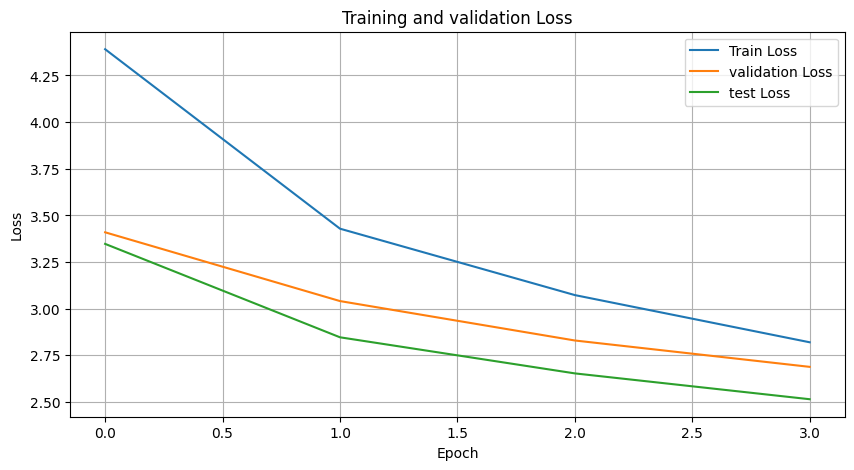

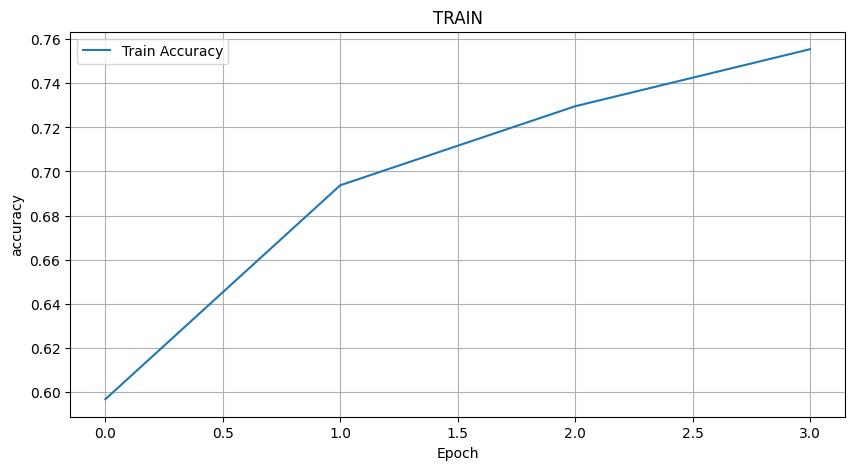

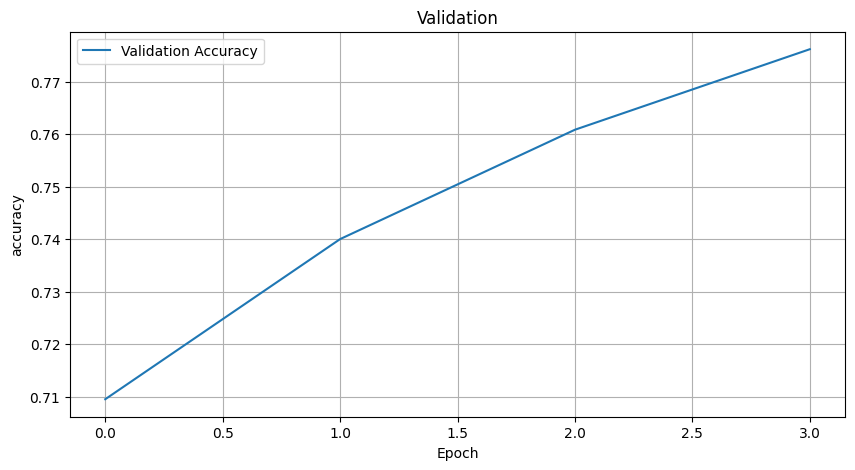

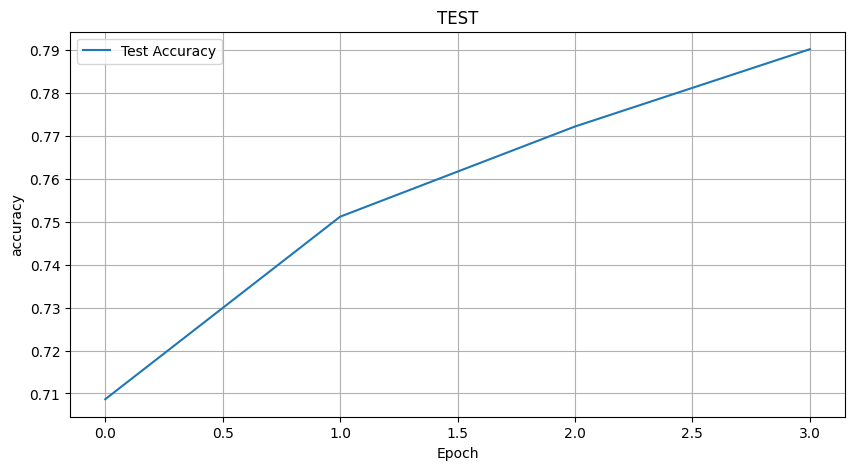

Train batch 1 / 150 in epoch 5
Train batch 2 / 150 in epoch 5
Train batch 3 / 150 in epoch 5
Train batch 4 / 150 in epoch 5
Train batch 5 / 150 in epoch 5
Train batch 6 / 150 in epoch 5
Train batch 7 / 150 in epoch 5
Train batch 8 / 150 in epoch 5
Train batch 9 / 150 in epoch 5
Train batch 10 / 150 in epoch 5
Train batch 11 / 150 in epoch 5
Train batch 12 / 150 in epoch 5
Train batch 13 / 150 in epoch 5
Train batch 14 / 150 in epoch 5
Train batch 15 / 150 in epoch 5
Train batch 16 / 150 in epoch 5
Train batch 17 / 150 in epoch 5
Train batch 18 / 150 in epoch 5
Train batch 19 / 150 in epoch 5
Train batch 20 / 150 in epoch 5
Train batch 21 / 150 in epoch 5
Train batch 22 / 150 in epoch 5
Train batch 23 / 150 in epoch 5
Train batch 24 / 150 in epoch 5
Train batch 25 / 150 in epoch 5
Train batch 26 / 150 in epoch 5
Train batch 27 / 150 in epoch 5
Train batch 28 / 150 in epoch 5
Train batch 29 / 150 in epoch 5
Train batch 30 / 150 in epoch 5
Train batch 31 / 150 in epoch 5
Train batch 32 / 

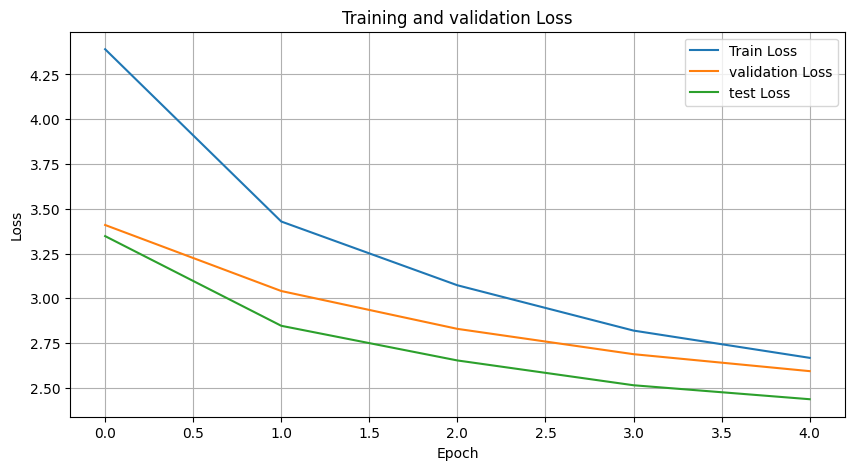

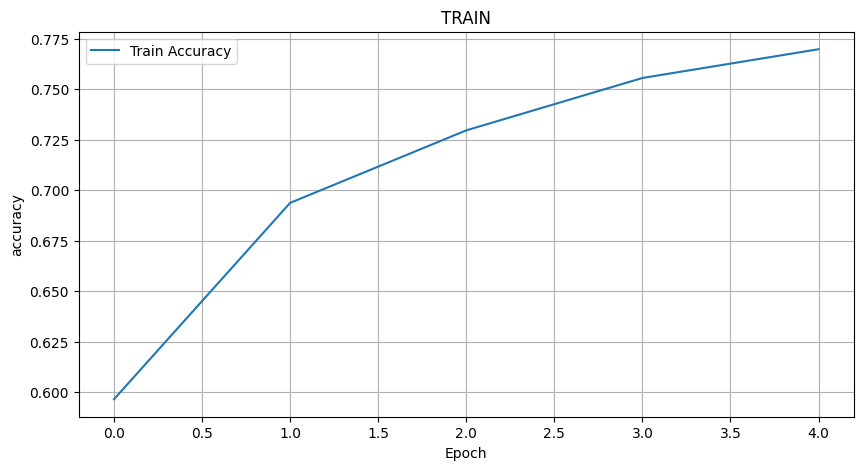

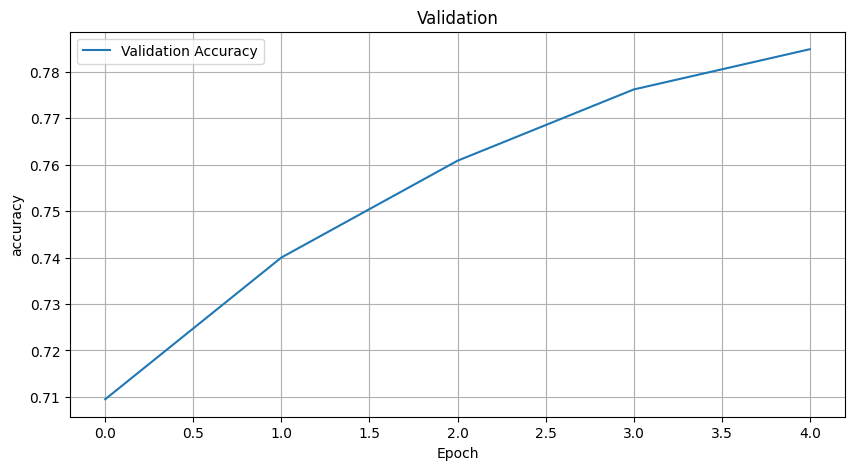

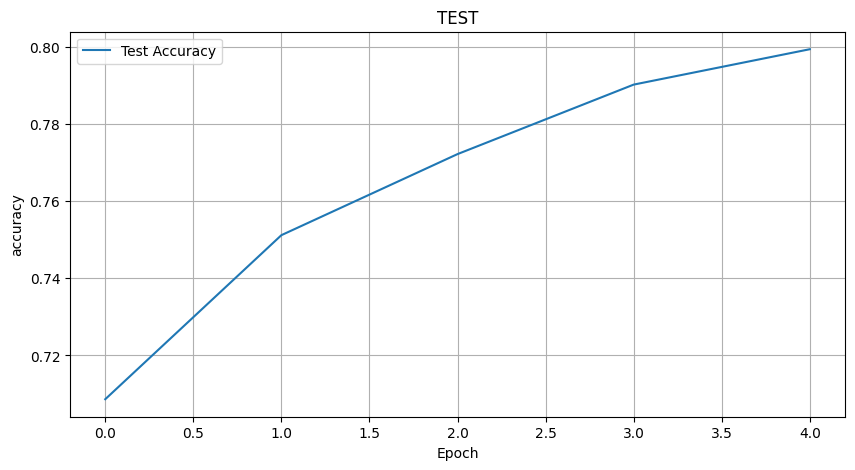

Train batch 1 / 150 in epoch 6
Train batch 2 / 150 in epoch 6
Train batch 3 / 150 in epoch 6
Train batch 4 / 150 in epoch 6
Train batch 5 / 150 in epoch 6
Train batch 6 / 150 in epoch 6
Train batch 7 / 150 in epoch 6
Train batch 8 / 150 in epoch 6
Train batch 9 / 150 in epoch 6
Train batch 10 / 150 in epoch 6
Train batch 11 / 150 in epoch 6
Train batch 12 / 150 in epoch 6
Train batch 13 / 150 in epoch 6
Train batch 14 / 150 in epoch 6
Train batch 15 / 150 in epoch 6
Train batch 16 / 150 in epoch 6
Train batch 17 / 150 in epoch 6
Train batch 18 / 150 in epoch 6
Train batch 19 / 150 in epoch 6
Train batch 20 / 150 in epoch 6
Train batch 21 / 150 in epoch 6
Train batch 22 / 150 in epoch 6
Train batch 23 / 150 in epoch 6
Train batch 24 / 150 in epoch 6
Train batch 25 / 150 in epoch 6
Train batch 26 / 150 in epoch 6
Train batch 27 / 150 in epoch 6
Train batch 28 / 150 in epoch 6
Train batch 29 / 150 in epoch 6
Train batch 30 / 150 in epoch 6
Train batch 31 / 150 in epoch 6
Train batch 32 / 

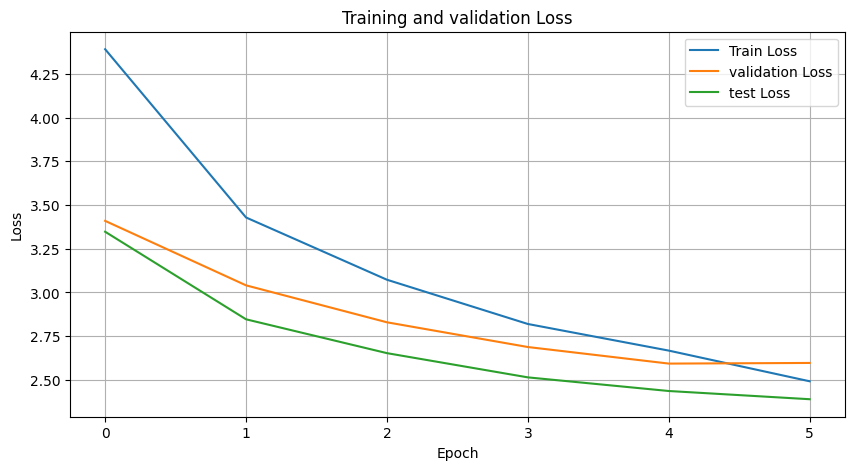

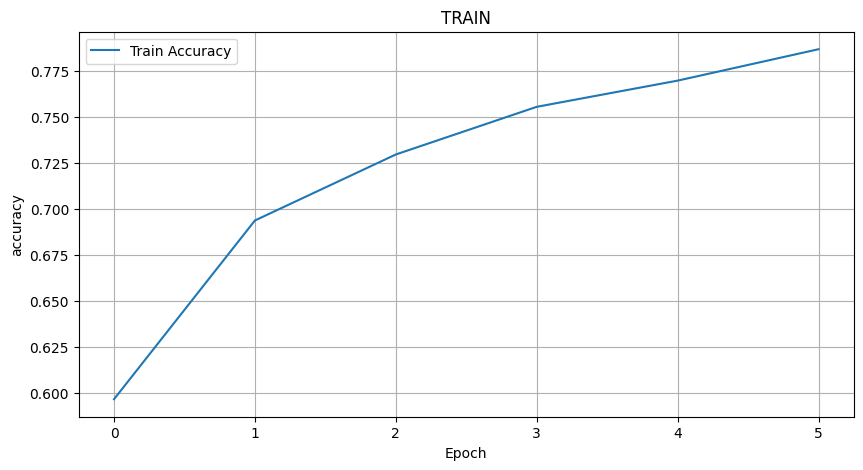

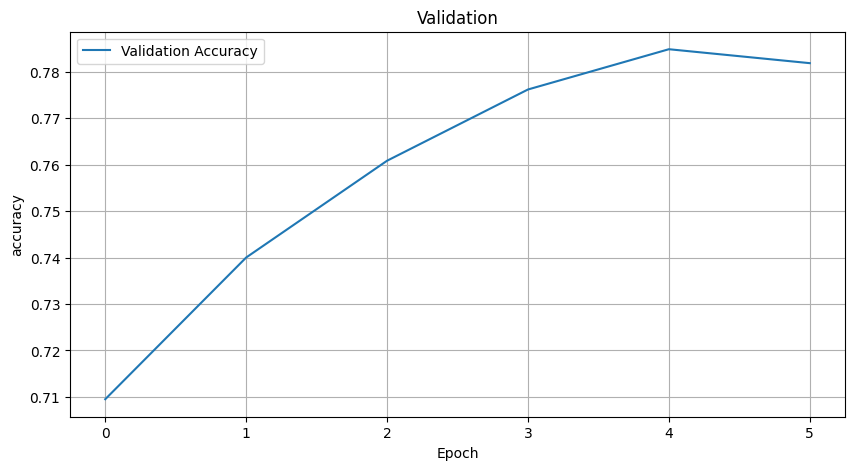

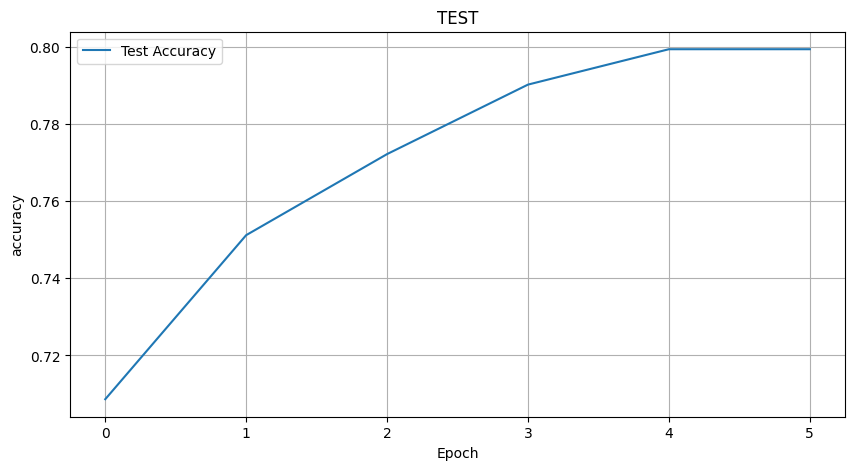

Train batch 1 / 150 in epoch 7
Train batch 2 / 150 in epoch 7
Train batch 3 / 150 in epoch 7
Train batch 4 / 150 in epoch 7
Train batch 5 / 150 in epoch 7
Train batch 6 / 150 in epoch 7
Train batch 7 / 150 in epoch 7
Train batch 8 / 150 in epoch 7
Train batch 9 / 150 in epoch 7
Train batch 10 / 150 in epoch 7
Train batch 11 / 150 in epoch 7
Train batch 12 / 150 in epoch 7
Train batch 13 / 150 in epoch 7
Train batch 14 / 150 in epoch 7
Train batch 15 / 150 in epoch 7
Train batch 16 / 150 in epoch 7
Train batch 17 / 150 in epoch 7
Train batch 18 / 150 in epoch 7
Train batch 19 / 150 in epoch 7
Train batch 20 / 150 in epoch 7
Train batch 21 / 150 in epoch 7
Train batch 22 / 150 in epoch 7
Train batch 23 / 150 in epoch 7
Train batch 24 / 150 in epoch 7
Train batch 25 / 150 in epoch 7
Train batch 26 / 150 in epoch 7
Train batch 27 / 150 in epoch 7
Train batch 28 / 150 in epoch 7
Train batch 29 / 150 in epoch 7
Train batch 30 / 150 in epoch 7
Train batch 31 / 150 in epoch 7
Train batch 32 / 

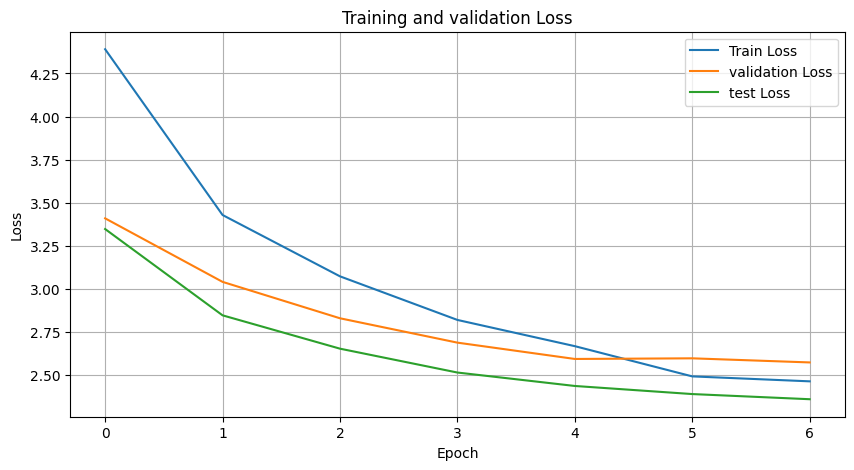

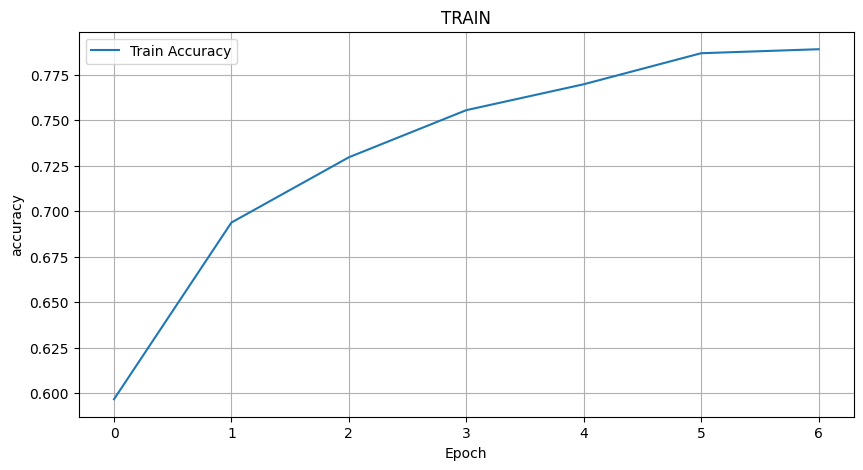

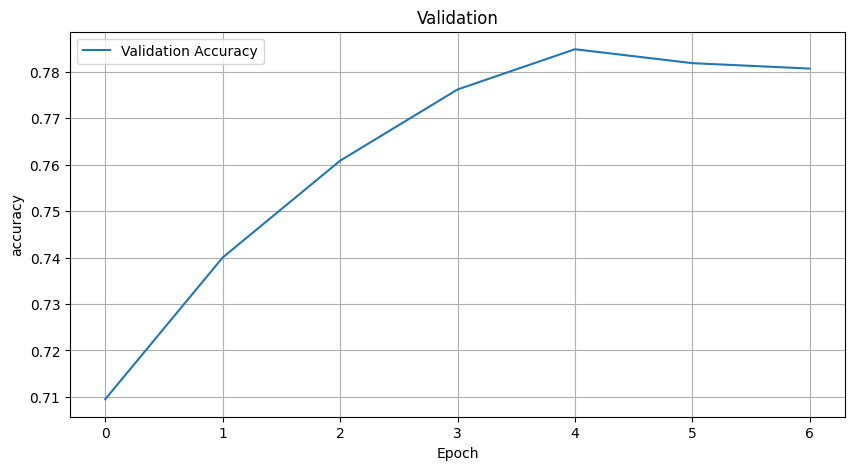

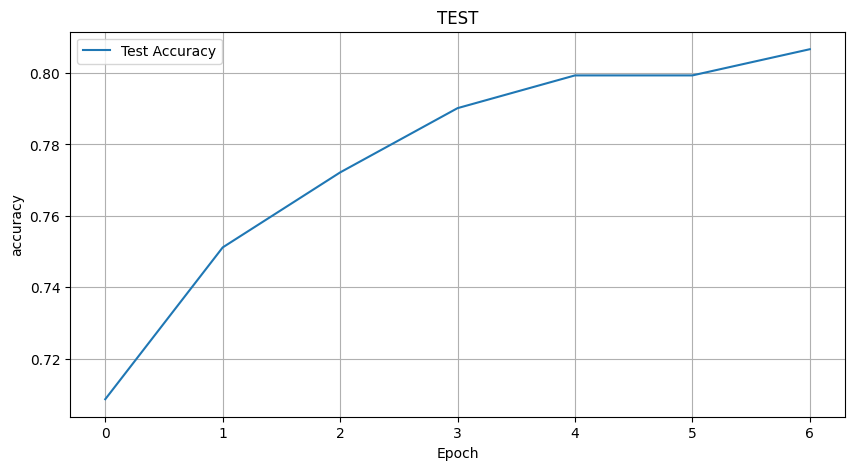

Train batch 1 / 150 in epoch 8
Train batch 2 / 150 in epoch 8
Train batch 3 / 150 in epoch 8
Train batch 4 / 150 in epoch 8
Train batch 5 / 150 in epoch 8
Train batch 6 / 150 in epoch 8
Train batch 7 / 150 in epoch 8
Train batch 8 / 150 in epoch 8
Train batch 9 / 150 in epoch 8
Train batch 10 / 150 in epoch 8
Train batch 11 / 150 in epoch 8
Train batch 12 / 150 in epoch 8
Train batch 13 / 150 in epoch 8
Train batch 14 / 150 in epoch 8
Train batch 15 / 150 in epoch 8
Train batch 16 / 150 in epoch 8
Train batch 17 / 150 in epoch 8
Train batch 18 / 150 in epoch 8
Train batch 19 / 150 in epoch 8
Train batch 20 / 150 in epoch 8
Train batch 21 / 150 in epoch 8
Train batch 22 / 150 in epoch 8
Train batch 23 / 150 in epoch 8
Train batch 24 / 150 in epoch 8
Train batch 25 / 150 in epoch 8
Train batch 26 / 150 in epoch 8
Train batch 27 / 150 in epoch 8
Train batch 28 / 150 in epoch 8
Train batch 29 / 150 in epoch 8
Train batch 30 / 150 in epoch 8
Train batch 31 / 150 in epoch 8
Train batch 32 / 

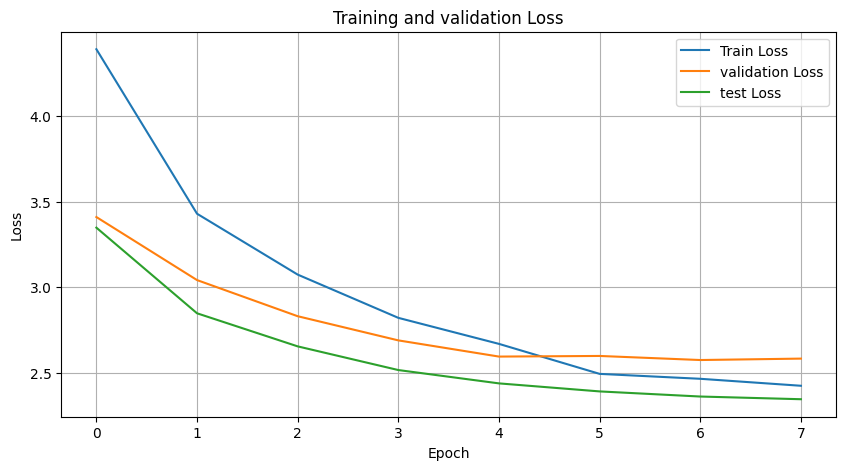

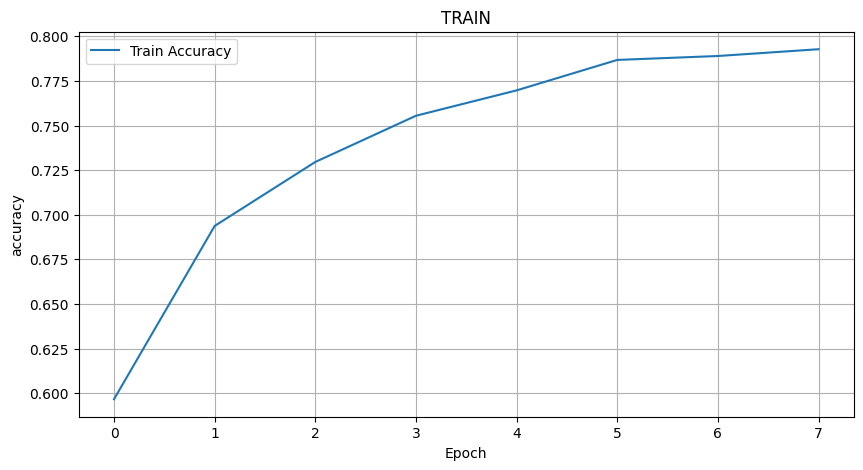

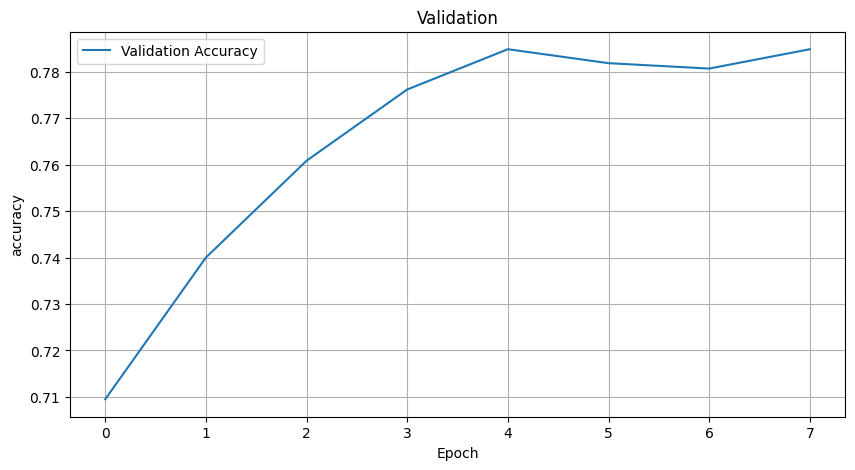

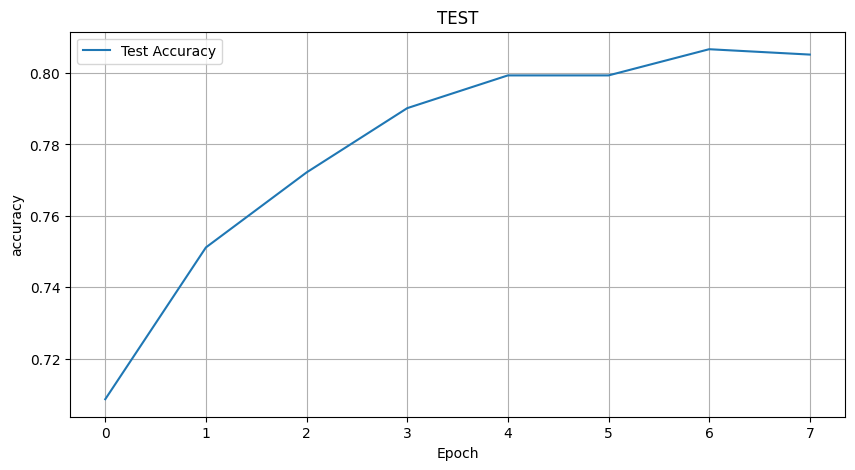

Train batch 1 / 150 in epoch 9
Train batch 2 / 150 in epoch 9
Train batch 3 / 150 in epoch 9
Train batch 4 / 150 in epoch 9
Train batch 5 / 150 in epoch 9
Train batch 6 / 150 in epoch 9
Train batch 7 / 150 in epoch 9
Train batch 8 / 150 in epoch 9
Train batch 9 / 150 in epoch 9
Train batch 10 / 150 in epoch 9
Train batch 11 / 150 in epoch 9
Train batch 12 / 150 in epoch 9
Train batch 13 / 150 in epoch 9
Train batch 14 / 150 in epoch 9
Train batch 15 / 150 in epoch 9
Train batch 16 / 150 in epoch 9
Train batch 17 / 150 in epoch 9
Train batch 18 / 150 in epoch 9
Train batch 19 / 150 in epoch 9
Train batch 20 / 150 in epoch 9
Train batch 21 / 150 in epoch 9
Train batch 22 / 150 in epoch 9
Train batch 23 / 150 in epoch 9
Train batch 24 / 150 in epoch 9
Train batch 25 / 150 in epoch 9
Train batch 26 / 150 in epoch 9
Train batch 27 / 150 in epoch 9
Train batch 28 / 150 in epoch 9
Train batch 29 / 150 in epoch 9
Train batch 30 / 150 in epoch 9
Train batch 31 / 150 in epoch 9
Train batch 32 / 

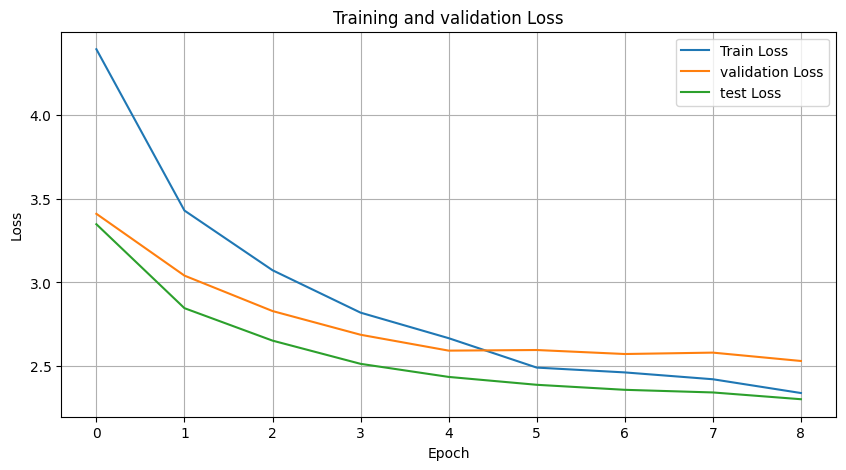

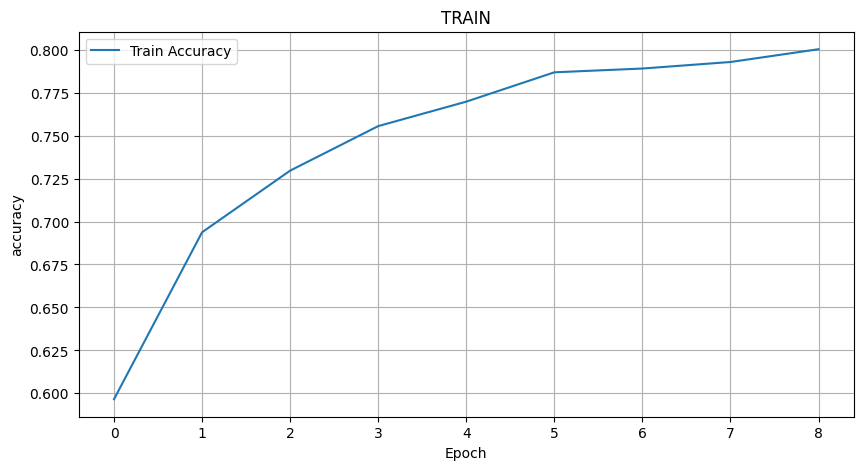

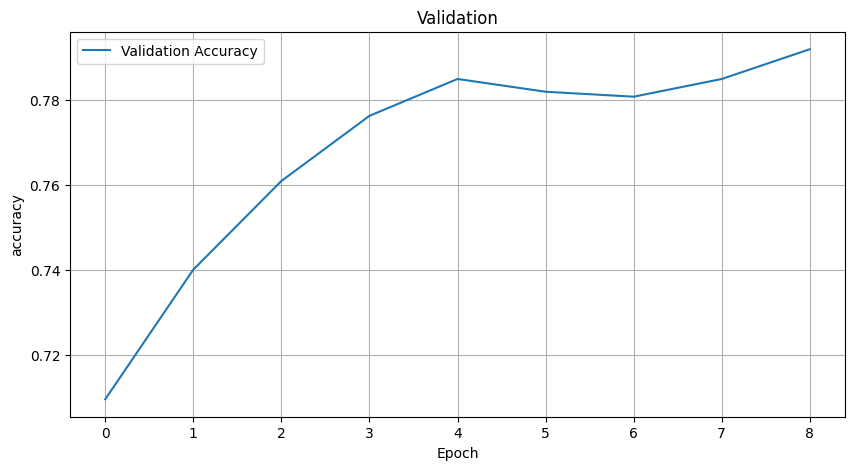

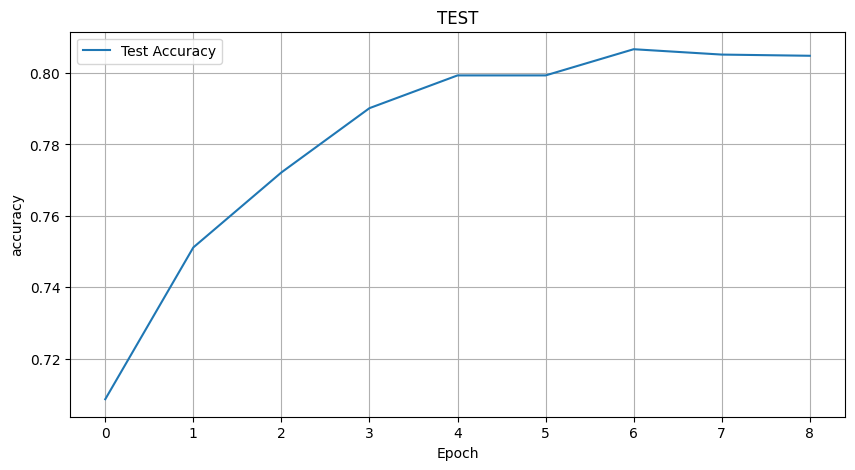

Train batch 1 / 150 in epoch 10
Train batch 2 / 150 in epoch 10
Train batch 3 / 150 in epoch 10
Train batch 4 / 150 in epoch 10
Train batch 5 / 150 in epoch 10
Train batch 6 / 150 in epoch 10
Train batch 7 / 150 in epoch 10
Train batch 8 / 150 in epoch 10
Train batch 9 / 150 in epoch 10
Train batch 10 / 150 in epoch 10
Train batch 11 / 150 in epoch 10
Train batch 12 / 150 in epoch 10
Train batch 13 / 150 in epoch 10
Train batch 14 / 150 in epoch 10
Train batch 15 / 150 in epoch 10
Train batch 16 / 150 in epoch 10
Train batch 17 / 150 in epoch 10
Train batch 18 / 150 in epoch 10
Train batch 19 / 150 in epoch 10
Train batch 20 / 150 in epoch 10
Train batch 21 / 150 in epoch 10
Train batch 22 / 150 in epoch 10
Train batch 23 / 150 in epoch 10
Train batch 24 / 150 in epoch 10
Train batch 25 / 150 in epoch 10
Train batch 26 / 150 in epoch 10
Train batch 27 / 150 in epoch 10
Train batch 28 / 150 in epoch 10
Train batch 29 / 150 in epoch 10
Train batch 30 / 150 in epoch 10
Train batch 31 / 15

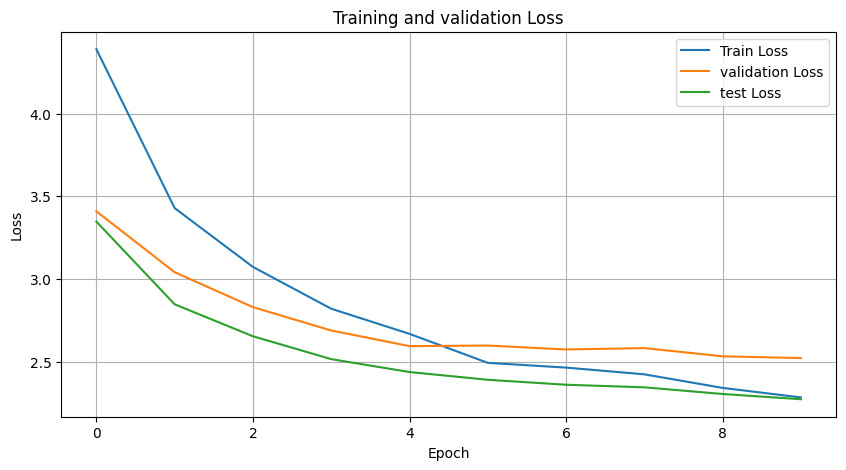

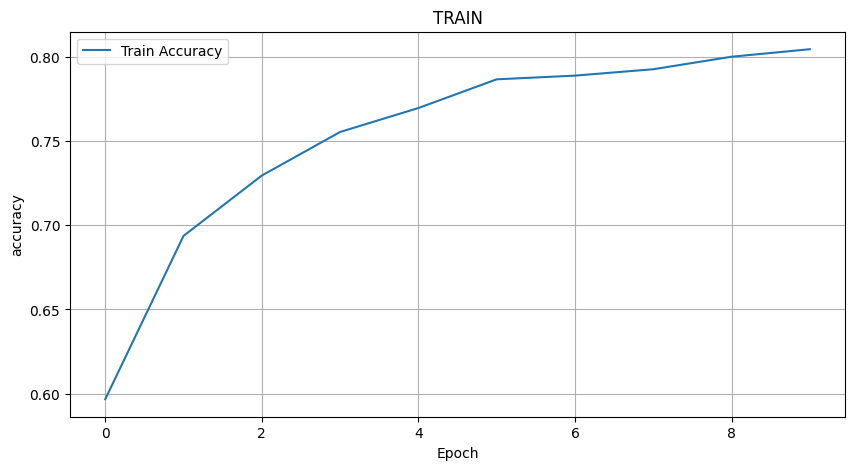

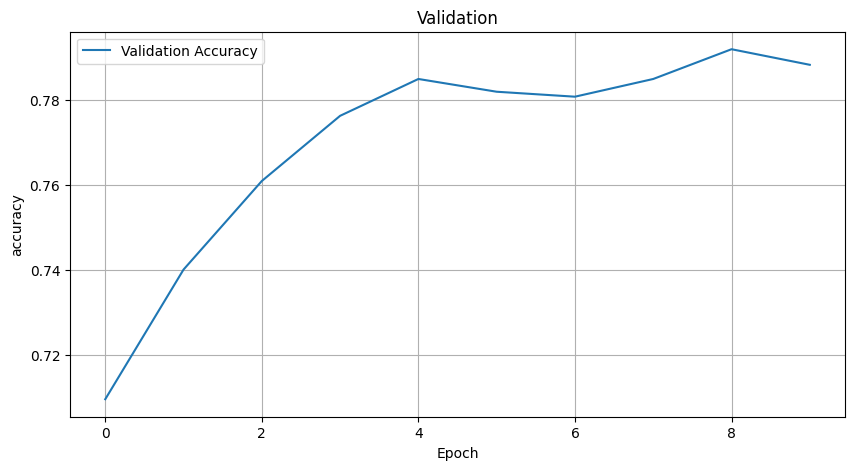

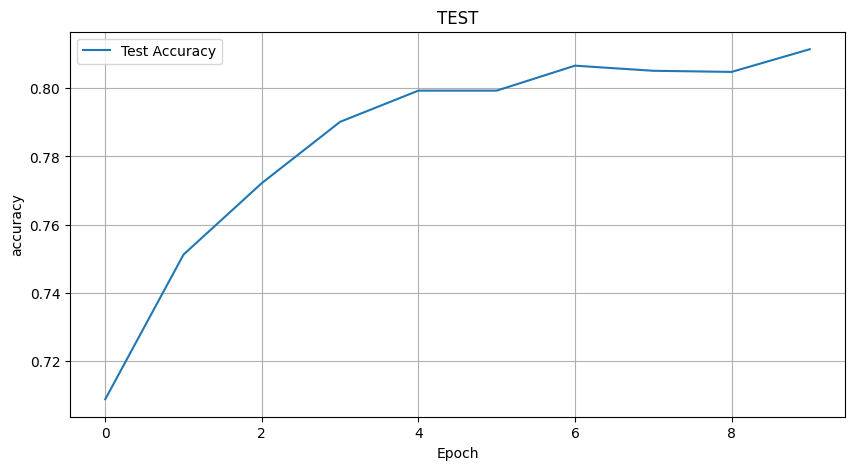

Train batch 1 / 150 in epoch 11
Train batch 2 / 150 in epoch 11
Train batch 3 / 150 in epoch 11
Train batch 4 / 150 in epoch 11
Train batch 5 / 150 in epoch 11
Train batch 6 / 150 in epoch 11
Train batch 7 / 150 in epoch 11
Train batch 8 / 150 in epoch 11
Train batch 9 / 150 in epoch 11
Train batch 10 / 150 in epoch 11
Train batch 11 / 150 in epoch 11
Train batch 12 / 150 in epoch 11
Train batch 13 / 150 in epoch 11
Train batch 14 / 150 in epoch 11
Train batch 15 / 150 in epoch 11
Train batch 16 / 150 in epoch 11
Train batch 17 / 150 in epoch 11
Train batch 18 / 150 in epoch 11
Train batch 19 / 150 in epoch 11
Train batch 20 / 150 in epoch 11
Train batch 21 / 150 in epoch 11
Train batch 22 / 150 in epoch 11
Train batch 23 / 150 in epoch 11
Train batch 24 / 150 in epoch 11
Train batch 25 / 150 in epoch 11
Train batch 26 / 150 in epoch 11
Train batch 27 / 150 in epoch 11
Train batch 28 / 150 in epoch 11
Train batch 29 / 150 in epoch 11
Train batch 30 / 150 in epoch 11
Train batch 31 / 15

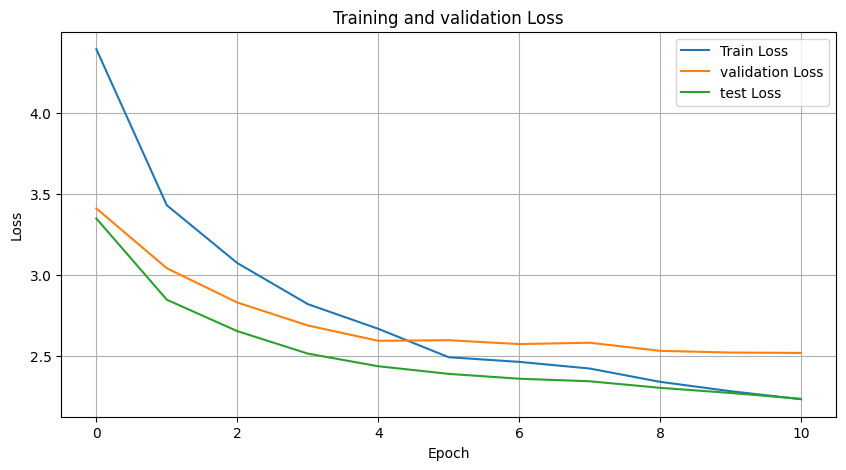

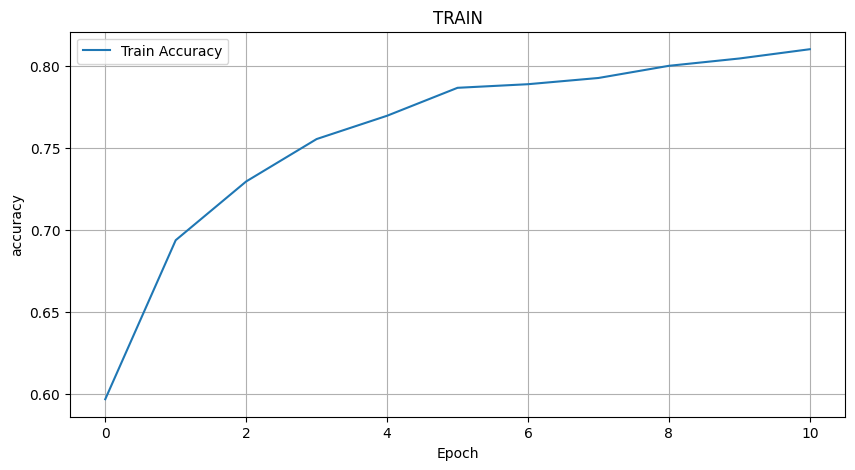

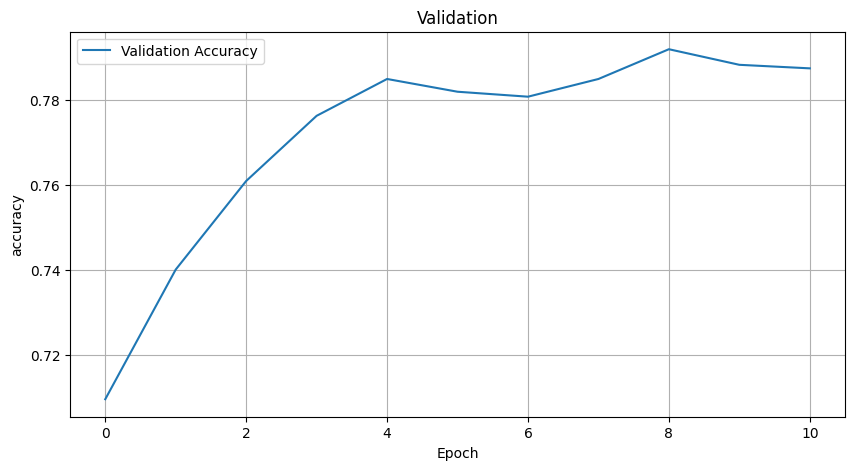

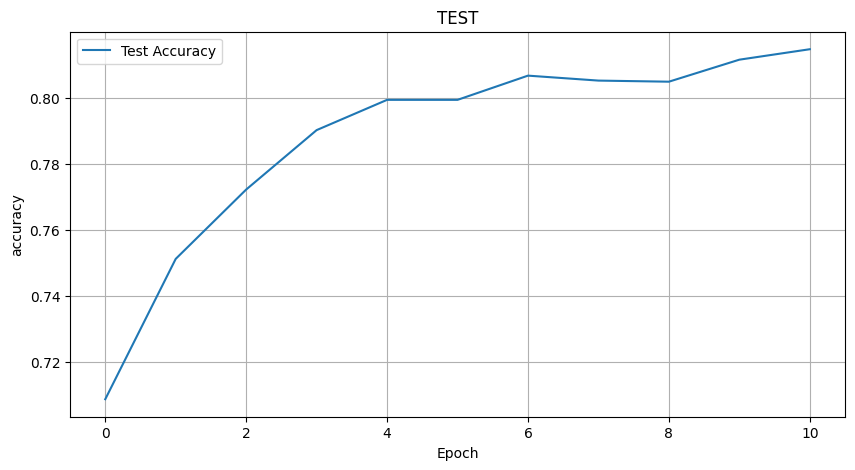

Train batch 1 / 150 in epoch 12
Train batch 2 / 150 in epoch 12
Train batch 3 / 150 in epoch 12
Train batch 4 / 150 in epoch 12
Train batch 5 / 150 in epoch 12
Train batch 6 / 150 in epoch 12
Train batch 7 / 150 in epoch 12
Train batch 8 / 150 in epoch 12
Train batch 9 / 150 in epoch 12
Train batch 10 / 150 in epoch 12
Train batch 11 / 150 in epoch 12
Train batch 12 / 150 in epoch 12
Train batch 13 / 150 in epoch 12
Train batch 14 / 150 in epoch 12
Train batch 15 / 150 in epoch 12
Train batch 16 / 150 in epoch 12
Train batch 17 / 150 in epoch 12
Train batch 18 / 150 in epoch 12
Train batch 19 / 150 in epoch 12
Train batch 20 / 150 in epoch 12
Train batch 21 / 150 in epoch 12
Train batch 22 / 150 in epoch 12
Train batch 23 / 150 in epoch 12
Train batch 24 / 150 in epoch 12
Train batch 25 / 150 in epoch 12
Train batch 26 / 150 in epoch 12
Train batch 27 / 150 in epoch 12
Train batch 28 / 150 in epoch 12
Train batch 29 / 150 in epoch 12
Train batch 30 / 150 in epoch 12
Train batch 31 / 15

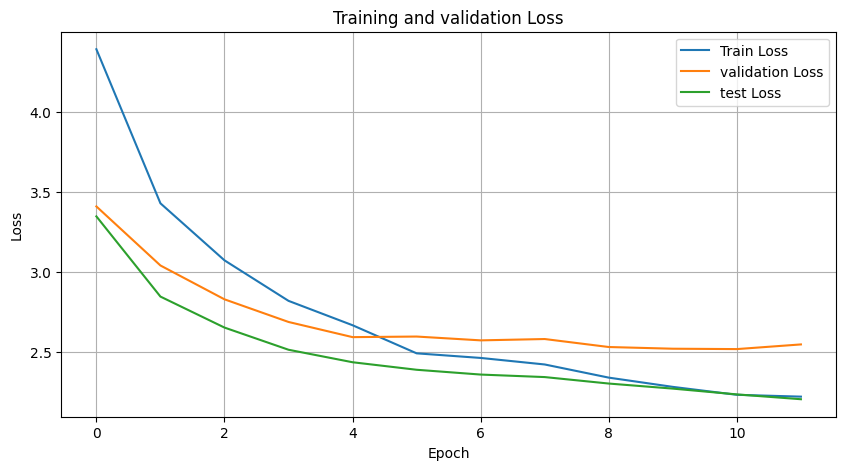

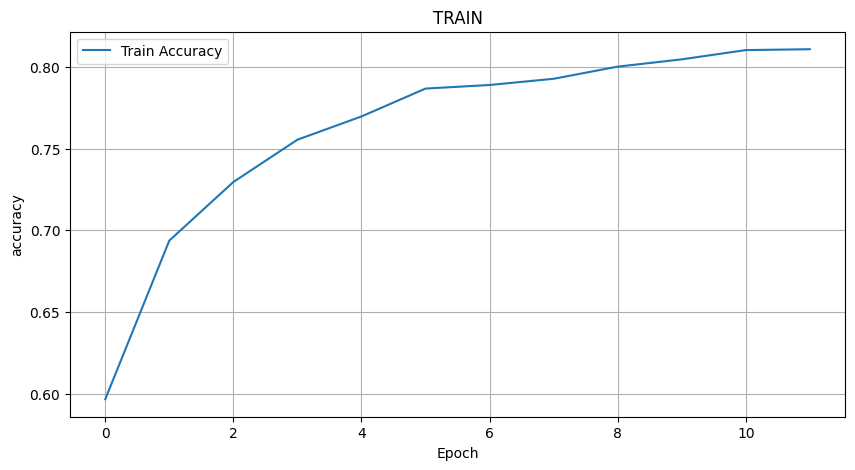

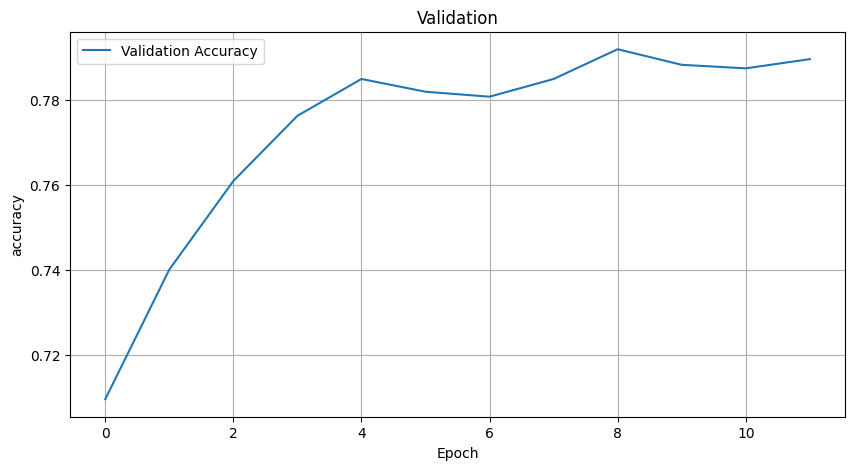

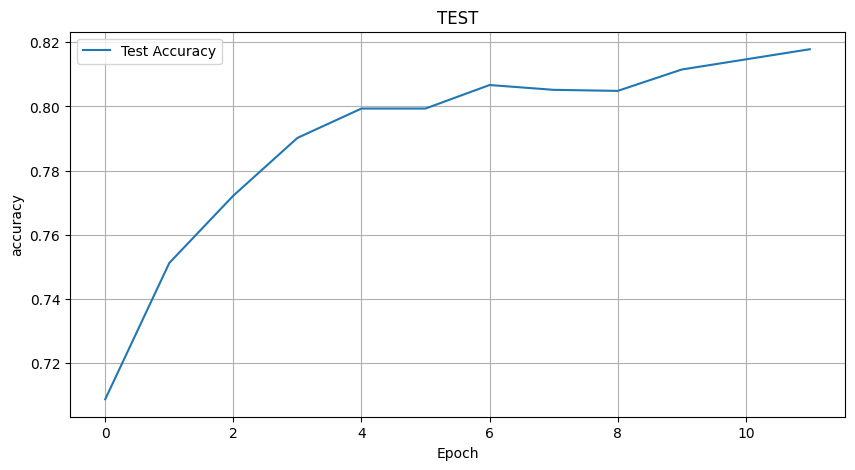

In [ ]:
# @title train and validation and test loops
import torch.nn.utils as torch_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
margin = 5
batch_size = 200
validation_batches = generate_batches(VD, batch_size)

test_batches = generate_batches(TESTD, batch_size)

siamese_net = SiameseNetwork()

siamese_net.to(device)
optimizer = optim.Adam(siamese_net.parameters(), lr=0.00001,weight_decay=0.001)

num_epochs = 20

train_accuracy = []
train_losses = []

validation_losses = []
validation_accuracy =[]

test_losses = []
test_accuracy =[]

ep_num = 0
for epoch in range(num_epochs):
    ep_num += 1
    siamese_net.train()
    training_loss = 0.0
    x = 0
    train_acc = 0.0
    TD = create_triplets_temp(train_images,train_labels,30000,"/content/newtraintemp/train_images_11_4")
    random.shuffle(TD)
    batches = generate_batches(TD, batch_size)
    Train_batches_len = len(batches)
    Validation_batches_len = len(validation_batches)
    Test_batches_len = len(test_batches)

    for batch in batches:
        x = x + 1
        print(f"Train batch {x} / {Train_batches_len} in epoch {ep_num}")
        input1, input2, input3 = [], [], []

        for item in batch:
            im1, im2, im3 = item[0], item[1], item[2]
            image1 = Image.open("/content/newtraintemp/train_images_11_4" + "/" + im1)
            image2 = Image.open("/content/newtraintemp/train_images_11_4" + "/" + im2)
            image3 = Image.open("/content/newtraintemp/train_images_11_4" + "/" + im3)

            input1.append(image1)
            input2.append(image2)
            input3.append(image3)

        optimizer.zero_grad()
        input1 = torch.stack([transform_n(img1).to(device) for img1 in input1])
        input2 = torch.stack([transform_n(img2).to(device) for img2 in input2])
        input3 = torch.stack([transform_n(img3).to(device) for img3 in input3])

        output1= siamese_net(input1)
        output2= siamese_net(input2)
        output3= siamese_net(input3)

        loss, distpos , distneg = TripletLoss(output1, output2, output3,margin)
        training_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += sum((distpos < distneg).float().int())/len(distpos)

    train_acc /= x
    epoch_train_loss = training_loss / x
    train_losses.append(epoch_train_loss)
    train_accuracy.append(train_acc.cpu().numpy())

    #############################################
    # Train loop end
    # Validation loop begin
    siamese_net.eval()
    validation_loss = 0.0
    validation_acc = 0.0
    z = 0
    with torch.no_grad():
      for batchV in validation_batches:
          z = z + 1
          input1, input2, input3 = [], [], []
          print(f"Validation batch {z} / {Validation_batches_len} in epoch {ep_num}")

          for item in batchV:
              im1, im2, im3 = item[0], item[1], item[2]
              image1 = Image.open("/content/newtraintemp/train_images_11_4" + "/" + im1)
              image2 = Image.open("/content/newtraintemp/train_images_11_4" + "/" + im2)
              image3 = Image.open("/content/newtraintemp/train_images_11_4" + "/" + im3)

              input1.append(image1)
              input2.append(image2)
              input3.append(image3)

          input1 = torch.stack([val_transform(img1).to(device) for img1 in input1])
          input2 = torch.stack([val_transform(img2).to(device) for img2 in input2])
          input3 = torch.stack([val_transform(img3).to(device) for img3 in input3])

          output1= siamese_net(input1)
          output2= siamese_net(input2)
          output3= siamese_net(input3)


          loss, distpos , distneg = TripletLoss(output1, output2, output3,margin)
          validation_loss += loss.item()
          validation_acc += sum((distpos<distneg).float().int())/len(distpos)
    save_path = "/content/drive/MyDrive/Colab/siamese_model" + str(ep_num)

    torch.save(siamese_net.state_dict(), save_path)
    validation_acc /= z
    validation_accuracy.append(validation_acc.cpu().numpy())
    epoch_validation_loss = validation_loss / z
    validation_losses.append(epoch_validation_loss)

    #############################################
    # Validation loop end
    # Test loop begin

    siamese_net.eval()
    test_acc = 0.0
    k = 0
    test_loss= 0.0
    with torch.no_grad():
      for batchT in test_batches:
          k = k + 1
          print(f"Test batch {k} / {Test_batches_len} in epoch {ep_num}")

          input1, input2, input3 = [], [], []
          for item in batchT:
              im1, im2, im3 = item[0], item[1], item[2]
              image1 = Image.open("/content/newtesttemp/newtest" + "/" + im1)
              image2 = Image.open("/content/newtesttemp/newtest" + "/" + im2)
              image3 = Image.open("/content/newtesttemp/newtest" + "/" + im3)
              input1.append(image1)
              input2.append(image2)
              input3.append(image3)

          input1 = torch.stack([val_transform(img1).to(device) for img1 in input1])
          input2 = torch.stack([val_transform(img2).to(device) for img2 in input2])
          input3 = torch.stack([val_transform(img3).to(device) for img3 in input3])

          output1= siamese_net(input1)
          output2= siamese_net(input2)
          output3= siamese_net(input3)


          loss, distpos , distneg = TripletLoss(output1, output2, output3,margin)
          test_loss += loss.item()
          test_acc +=sum((distpos < distneg).float().int())/(len(distpos))

    test_acc /= k
    epoch_test_loss = test_loss / k
    test_losses.append(epoch_test_loss)
    test_accuracy.append(test_acc.cpu().numpy())

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='validation Loss')
    plt.plot(test_losses, label='test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title('TRAIN')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title('Validation')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(test_accuracy, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title('TEST')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# @title Final resluts
import zipfile
import os
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

zip_path = 'test_data_images.zip'

extract_dir = 'newtesttemp/'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)

test_acc = 0.0
k = 0
margin = 5
batch_size = 200
siamese_net_test = SiameseNetwork()
siamese_net_test.to(device)

model_path = "/content/drive/MyDrive/Colab/siamese_model12"
siamese_net_test.load_state_dict(torch.load(model_path))


save_path = '/content/drive/MyDrive/Colab/'
with open(save_path + 'triplet_test_data_final.pkl', 'rb') as f:
    TESTD = pickle.load(f)

test_batches = generate_batches(TESTD, batch_size)


siamese_net_test.eval()
k = 0
test_loss= 0.0

acc_test = 0.0
with torch.no_grad():
  for batchT in test_batches:

      k = k + 1
      input1, input2, input3 = [], [], []

      for item in batchT:
          im1, im2, im3 = item[0], item[1], item[2]
          image1 = Image.open("/content/newtesttemp/newtest" + "/" + im1)
          image2 = Image.open("/content/newtesttemp/newtest" + "/" + im2)
          image3 = Image.open("/content/newtesttemp/newtest" + "/" + im3)
          input1.append(image1)
          input2.append(image2)
          input3.append(image3)
      input1 = torch.stack([val_transform(img1).to(device) for img1 in input1])
      input2 = torch.stack([val_transform(img2).to(device) for img2 in input2])
      input3 = torch.stack([val_transform(img3).to(device) for img3 in input3])


      output1= siamese_net_test(input1)
      output2= siamese_net_test(input2)
      output3= siamese_net_test(input3)


      loss, distpos , distneg = TripletLoss(output1, output2, output3,margin)
      acc_test += sum((distpos < distneg).float().int())/(len(distpos))

acc_test /= k
print(f"Accuracy for Test is: {acc_test.item()*100:.4f}%")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


Accuracy for Test is: 81.7833%
